# The Ultimate Inc. Data Science Challenge

In [46]:
import os
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import numpy as np
import json
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report,accuracy_score, roc_curve, precision_score
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 8)

In [3]:
#data file 
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [6]:
#Let's assign weekdays for all months 
logins['weekday'] = pd.to_datetime(logins['login_time']).apply(lambda x: x.weekday())
logins.head()

,login_time,weekday
0,1970-01-01 20:13:18,3
1,1970-01-01 20:16:10,3
2,1970-01-01 20:16:37,3
3,1970-01-01 20:16:36,3
4,1970-01-01 20:26:21,3


In [7]:
# Set login_time as index
logins.set_index('login_time', inplace=True)
logins['count'] = 1
logins = logins.resample('15T').sum() # count the logins for each 15 minutes.
logins.head()

,weekday,count
login_time,,
1970-01-01 20:00:00,6,2
1970-01-01 20:15:00,18,6
1970-01-01 20:30:00,27,9
1970-01-01 20:45:00,21,7
1970-01-01 21:00:00,3,1


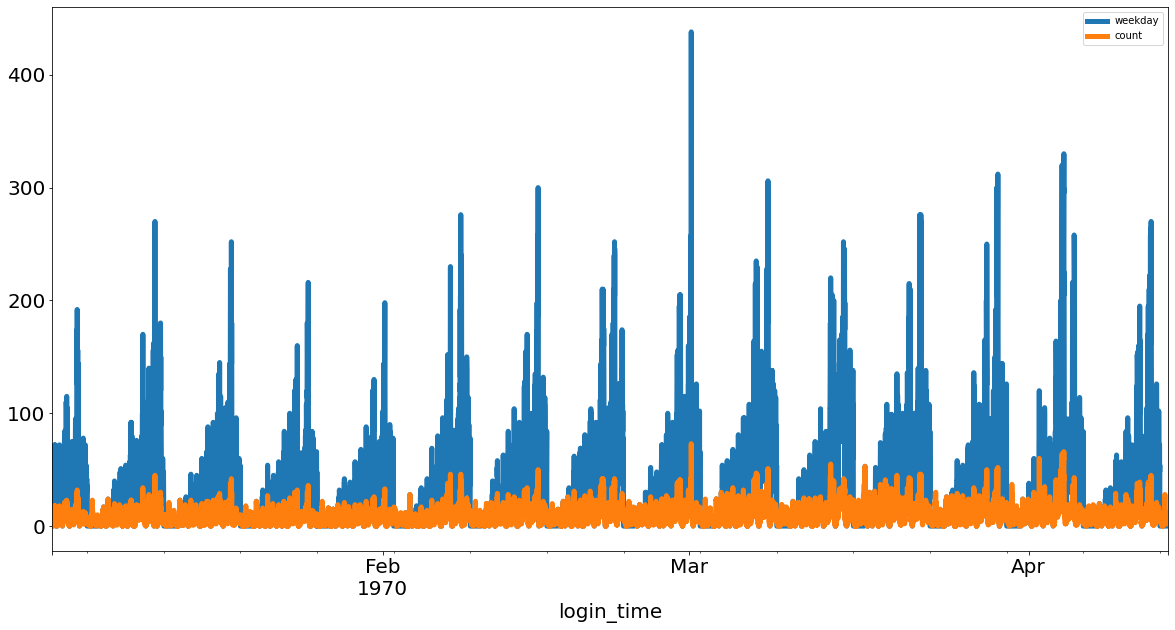

In [8]:
#plot the login_time
logins.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('login_time', fontsize=20);

Darkers areas on this plot represent trends. See trends during the weekends.

In [9]:
#Let's zoom in trends for each month
# Split by month into new dataframes
jan_df = logins['1970-01-01': '1970-01-31']
jan_df.reset_index(drop=False, inplace=True)

feb_df = logins['1970-02-01': '1970-02-28']
feb_df.reset_index(drop=False, inplace=True)

mar_df = logins['1970-03-01': '1970-03-31']
mar_df.reset_index(drop=False, inplace=True)

apr_df = logins['1970-04-01': '1970-04-30']
apr_df.reset_index(drop=False, inplace=True)


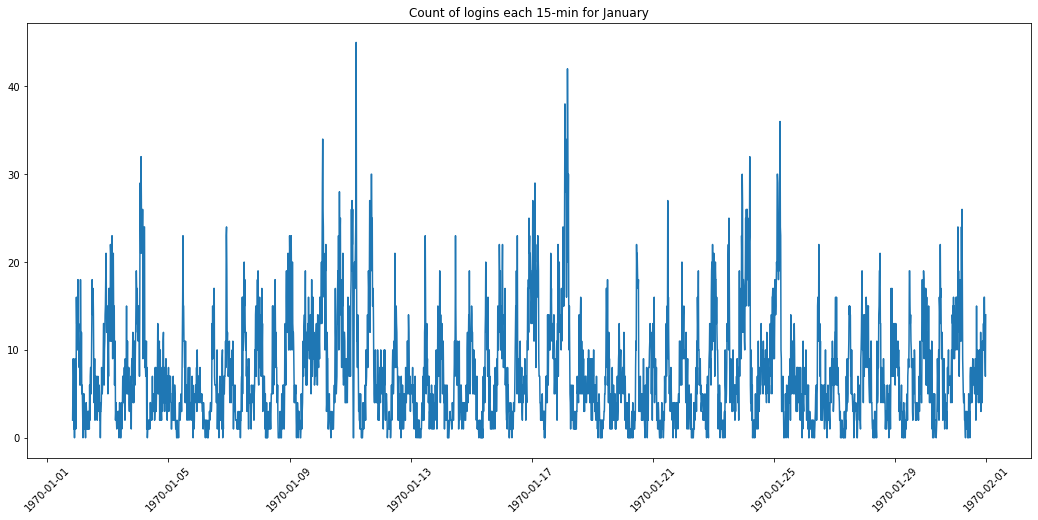

In [10]:
# January
x = jan_df['login_time']
y = jan_df['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for January')
plt.xticks(rotation=45);

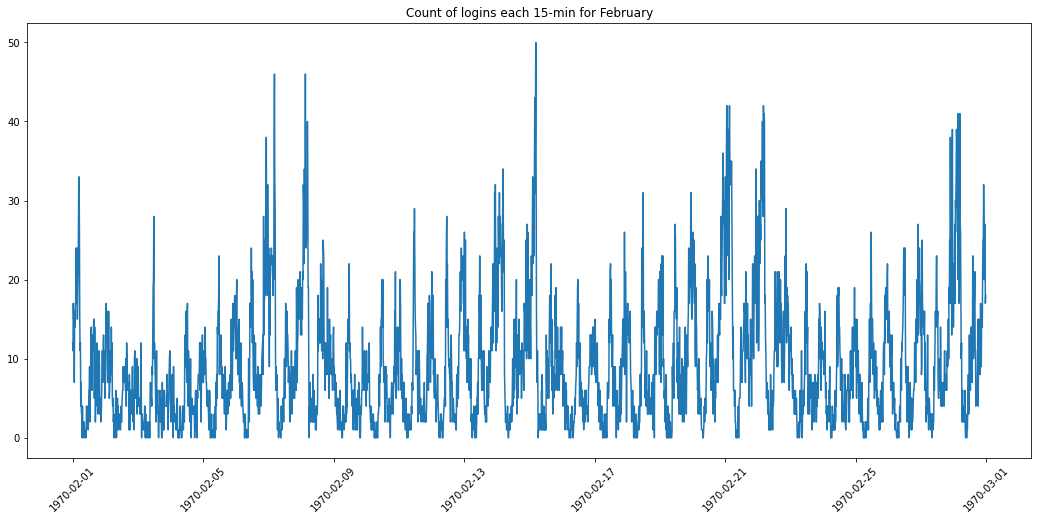

In [11]:
#February
x = feb_df['login_time']
y = feb_df['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for February')
plt.xticks(rotation=45);

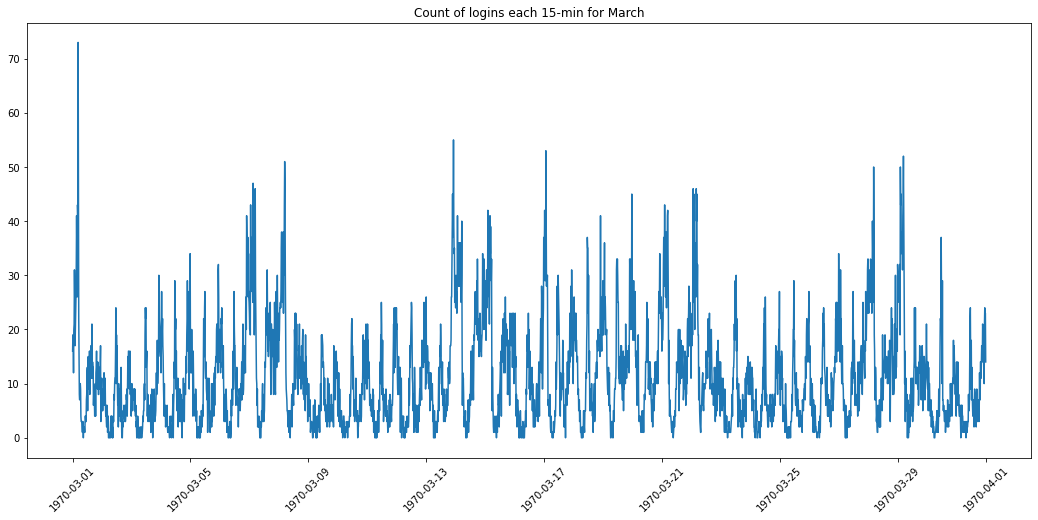

In [12]:
#March
x = mar_df['login_time']
y = mar_df['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for March')
plt.xticks(rotation=45);

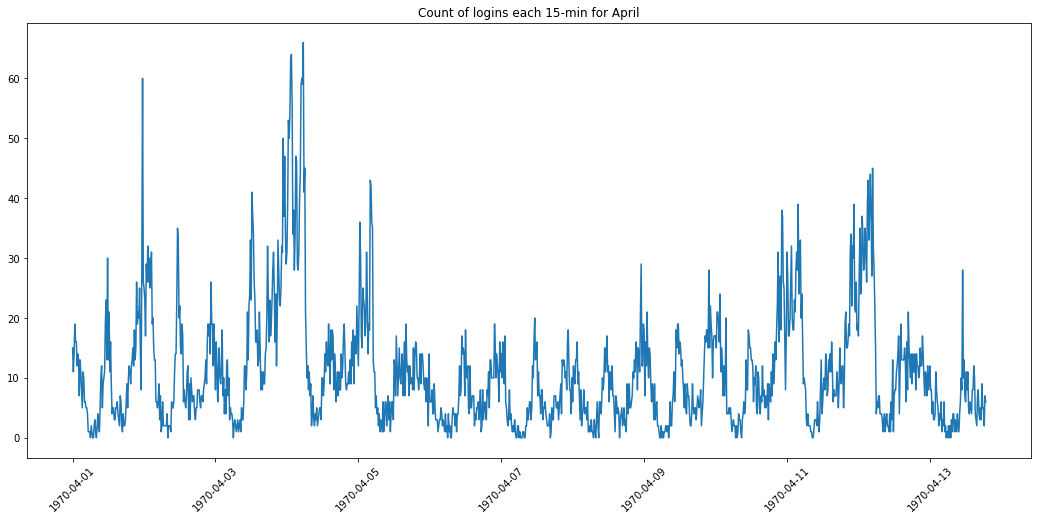

In [13]:
#April
x = apr_df['login_time']
y = apr_df['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for April')
plt.xticks(rotation=45);

In [14]:
jan_df['weekday'] = pd.to_datetime(jan_df['login_time']).apply(lambda x: x.weekday())
feb_df['weekday'] = pd.to_datetime(feb_df['login_time']).apply(lambda x: x.weekday())
mar_df['weekday'] = pd.to_datetime(mar_df['login_time']).apply(lambda x: x.weekday())
apr_df['weekday'] = pd.to_datetime(apr_df['login_time']).apply(lambda x: x.weekday())

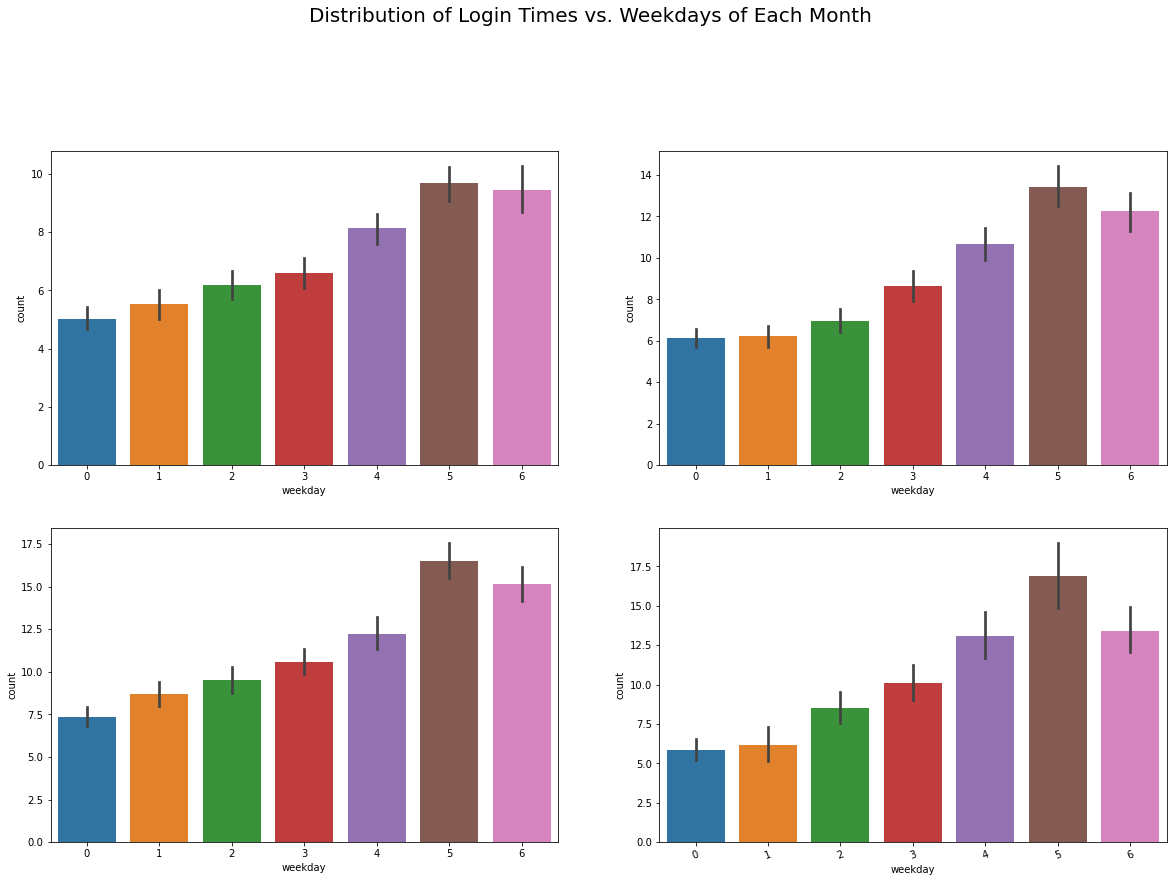

In [15]:
#Let's see how login times changing throughout the weekdays of January, February, March, April.
fig,ax = plt.subplots(2,2, figsize=(20,20))               
plt.suptitle("Distribution of Login Times vs. Weekdays of Each Month", fontsize=20)
sns.barplot(x='weekday', y='count', data=jan_df, ax = ax[0,0])
sns.barplot(x='weekday', y='count', data=feb_df, ax = ax[0,1])
sns.barplot(x='weekday', y='count', data=mar_df, ax = ax[1,0])
sns.barplot(x='weekday', y='count', data=apr_df, ax = ax[1,1])
plt.xticks(rotation=20)
plt.subplots_adjust(bottom=0.4)
plt.show()

It seems that spring brings more login times during the weekdays. Fridays and Saturdays have always highest peaks during the weeks. 

# Part 2: Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
how you will implement the experiment.
what statistical test(s) you will conduct to verify the significance of the observation.
how you would interpret the results and provide recommendations to the city operations team along with any caveats.

# Solution
1. We need to predict customers hourly demands during the weekdays for both city.
2. We can make an experiment related to drivers performance based on a point system to maximize the efficency and profit.

The prediction of customer demand can be conducted with number of customers signing up for each city driver. By this study, adding more taxi drivers for busy times of each city can increase the profit. Time series analysis will provide to see trends and seasonalities during those time periods. So,drivers would be aware more about their duration times in each city during the week. 
As an another suggestion, I believe that ponting system can encourage drivers partners by improving their time management skills and it will be good service for customer satisfaction as a long term goal. Additionally, that pointong system will encourage drivers to use tolls. So, an experiment can be applied to half drivers belonging to pointing system and half of not. 
Both suggestion purpose to play long term goals in terms of customer satisfaction and maximazing the revenue.

# Part 3: Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).


# Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY MM DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday



# Cleaning, exploratory analysis, and/or visualizations of data

In [17]:
# Read in the data
import json

file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [19]:
#Let's assign 'last trip date' and 'signup_date' to datetime 
df['last_trip_date']= pd.to_datetime(df['last_trip_date'])
df['signup_date']=pd.to_datetime(df['signup_date'])

In [20]:
#Checking for any missing value
def ShowMissing(df):
    num_missing = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (100*df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_num_percent = pd.concat([num_missing, missing_percent], axis=1, 
                                    keys=['num_missing', 'missing_percent'])
    return missing_num_percent

In [21]:
#Look how many missing values do we have?
missing_num = ShowMissing(df)
missing_num

,num_missing,missing_percent
avg_rating_of_driver,8122,16.244
phone,396,0.792
avg_rating_by_driver,201,0.402
avg_dist,0,0.000
weekday_pct,0,0.000
ultimate_black_user,0,0.000
surge_pct,0,0.000
last_trip_date,0,0.000
avg_surge,0,0.000
signup_date,0,0.000


In [22]:
#Let's look at data type of 'avg_rating_of_driver', 'phone' and 'avg_rating_by_driver'
print(df['avg_rating_of_driver'].dtype)
print(df['phone'].dtype)
print(df['avg_rating_by_driver'].dtype)

float64
object
float64


In [23]:
# Fill in missing values
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median(), inplace=True)

In [24]:
df['phone'].value_counts()# Since 'phone' is the categorical variable and 'iphone' is more popular under this category, 
                            #we can fill its missings with 'iphone'.

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [25]:
df['phone'].fillna('iPhone', inplace=True)

In [26]:
#Is any missing values left?
missing_num = ShowMissing(df)
missing_num

,num_missing,missing_percent
avg_rating_by_driver,0,0.0
avg_dist,0,0.0
weekday_pct,0,0.0
ultimate_black_user,0,0.0
surge_pct,0,0.0
phone,0,0.0
last_trip_date,0,0.0
avg_surge,0,0.0
avg_rating_of_driver,0,0.0
signup_date,0,0.0


# Data Visulizations

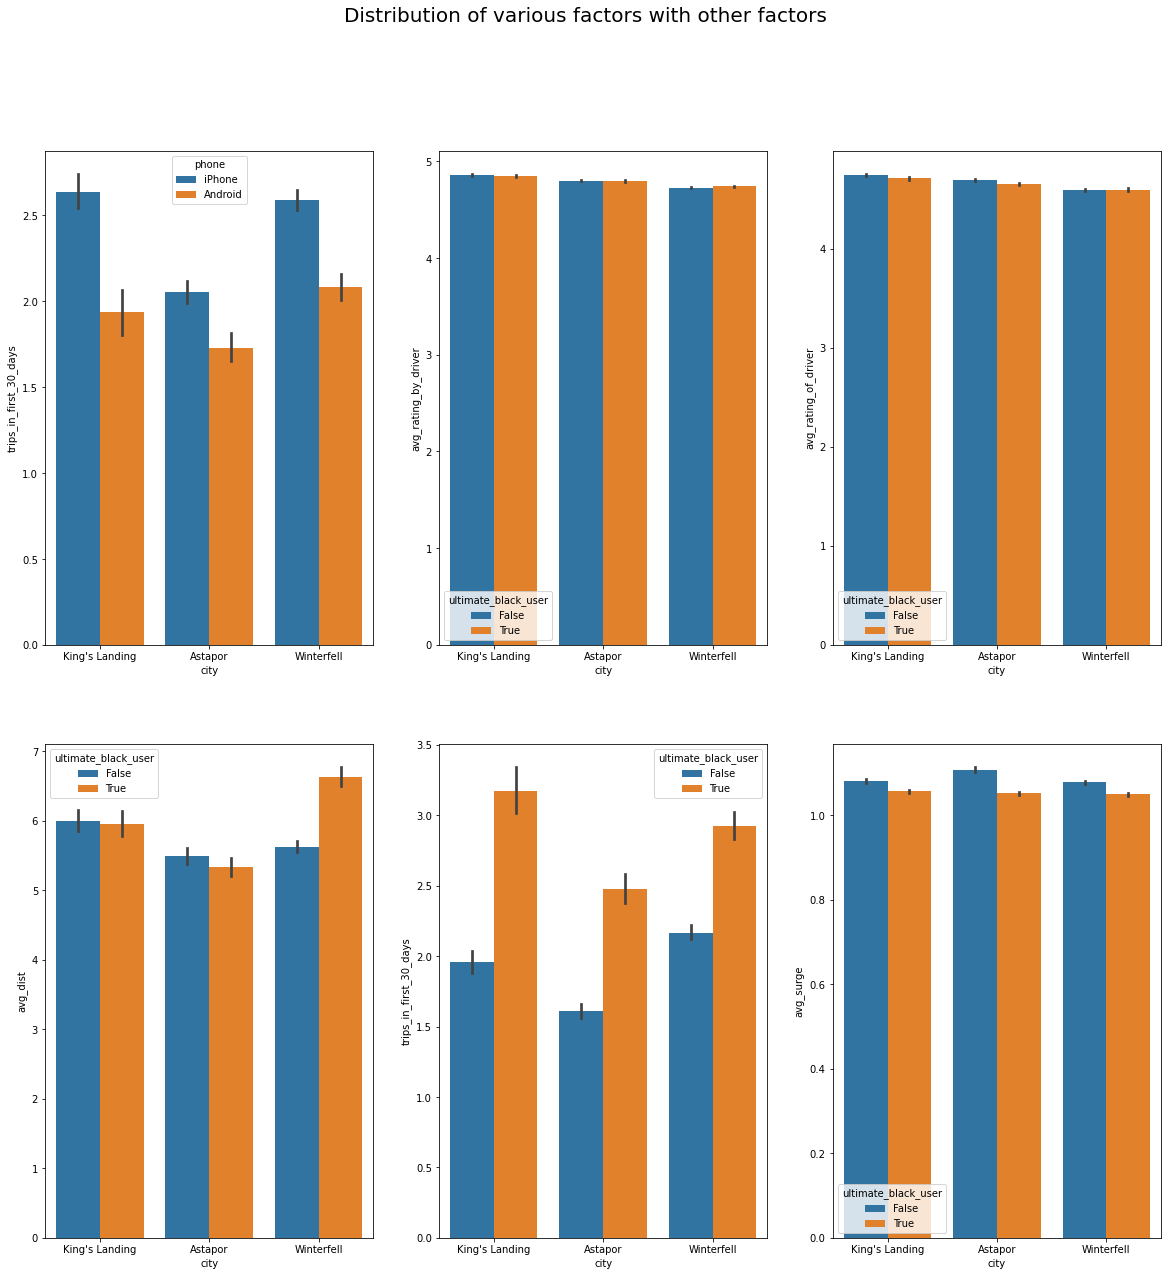

In [27]:
fig,ax = plt.subplots(2,3, figsize=(20,20))               
plt.suptitle("Distribution of various factors with other factors", fontsize=20)
sns.barplot(df['city'],df['trips_in_first_30_days'],hue = df['phone'], ax = ax[0,0]); 
sns.barplot(df['city'],df['avg_rating_by_driver'],hue = df['ultimate_black_user'], ax = ax[0,1]); 
sns.barplot(df['city'],df['avg_rating_of_driver'],hue = df['ultimate_black_user'],  ax = ax[0,2]); 
sns.barplot(df['city'],df['avg_dist'],hue = df['ultimate_black_user'], ax = ax[1,0]); 
sns.barplot(df['city'],df['trips_in_first_30_days'],hue = df['ultimate_black_user'],  ax = ax[1,1]); 
sns.barplot(df['city'],df['avg_surge'],hue = df['ultimate_black_user'],  ax = ax[1,2]);


- People of King's Landing who use iphone are more likely to trip in first 30 days.
- People from all three city who are ultimate black user have pretty same average rating over all of their trips
and average rating of their drivers over all of their trips.
- People from the city Winterfell who are ultimate black user have the highest average distance in miles per trip taken in the first 30 days after signup.
- Ultimate Black users from all cities have higher number of trips this user took in the first 30 days after signing up compare to non users.
- Ultimate Black users from all three city have lower avg_surge compare to non-users. 

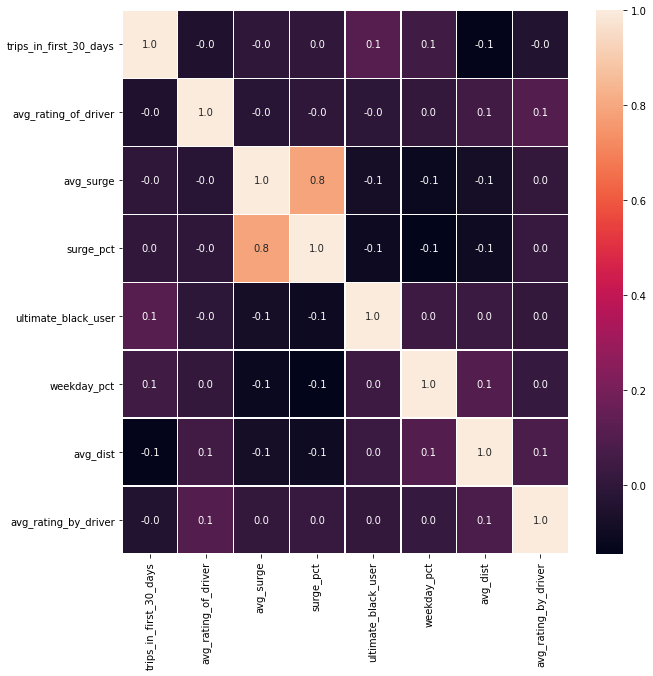

In [28]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

It seems that avg_surge and surge_pct is highly correlated, but they can be stayed due to keep number of variables high.

# What fraction of the observed users were retained? 

In [29]:
# Build a new variable
df['retained'] = np.nan
df.loc[df['last_trip_date'] >= '2014-06-01', 'retained'] = 1
df.loc[df['last_trip_date'] < '2014-06-01', 'retained'] = 0
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1.0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0.0


In [30]:
# Retained users
df['retained'].sum()/len(df)

0.37608

About 38% of users have taken a trip on or after June 1st, 2014 are 'retained'.

# Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system

In [31]:
# drop features related to target variable created before
df.drop('last_trip_date', axis=1, inplace=True)
df.drop('signup_date', axis=1, inplace=True)

In [32]:
# Assign the target variable 'retained'
y= df['retained'].values

In [33]:
# Dropping 'retained' values
df = df.drop('retained', axis=1)
df.head(3)

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,4.7,1.1,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,5.0,1.0,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,4.3,1.0,iPhone,0.0,False,100.0,0.77,5.0


In [34]:
# Convert Categorical variables to dummy variables
df_encoded = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])
df_encoded.head(3)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.1,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,5.0,1.0,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,4.3,1.0,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0


In [35]:
# Setting X 
X = df_encoded.values

In [36]:
#Split data set into training set and test set with the 80 to 20 ratio
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [38]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.716


In [39]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.72


The average accuracy remains very close to the Logistic Regression model accuracy; hence, we can conclude that our model generalizes well.

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[5383  868]
 [1902 1847]]


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.86      0.80      6251
         1.0       0.68      0.49      0.57      3749

    accuracy                           0.72     10000
   macro avg       0.71      0.68      0.68     10000
weighted avg       0.72      0.72      0.71     10000



# Random Forest

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

In [47]:
#Calculate Accuracy Score for Random Forest
from sklearn.model_selection import train_test_split
predicted = model.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(accuracy)

0.76008


In [48]:
#Classification Report for Random Forest
from sklearn import metrics
print(metrics.classification_report(ypred, y_test))


              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81      7967
         1.0       0.66      0.69      0.67      4533

    accuracy                           0.76     12500
   macro avg       0.74      0.74      0.74     12500
weighted avg       0.76      0.76      0.76     12500



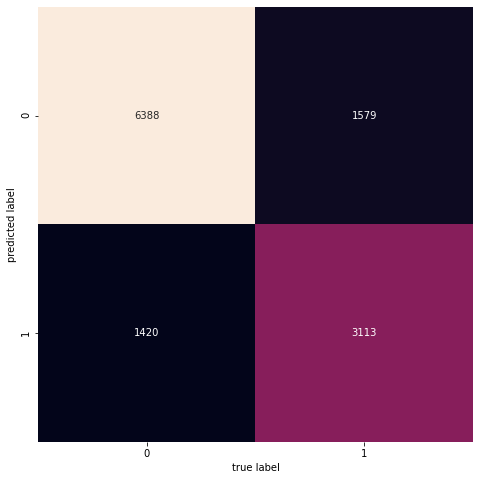

In [49]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Conclusion and future recommendations

- Random forest model have higher accuracy than the logistic regression, so random forest will be our optimal model with 76% accuracy shown in the confusion matrix.
- Under this model, the feature importance provide the level of importance of predictors on estimating retained customers. 
